In [37]:
hives_ids = ["smrpiclient7", "smrpiclient6", "smrpiclient3"]

# define hive under analysis
hive_under_analysis = hives_ids[0]
# define offset as all data should be utc
timezone_offset_hours = 2
# define if we should reinit our data
DATA_INIT = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing

Here we load train data sound samples and prepare spectrogram, periodogram and mfcc features (along with some data to visualize this). We should provide data with **utc timestamps** as it will be shifted with `timezone_offset_hours` var. What we also do is remove those samples which has strange rms signal. Threshold 0.8 was chosen based on `plot_distribution` output.


In [18]:
import numpy as np
a = np.array([[1,2],[1,2],[1,2],[1,2],[1,2],[1,2]])
print(a)
print(a.shape)
np.mean(a, axis=1)

[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]]
(6, 2)


array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5])

In [20]:
import numpy as np
import glob
import librosa

from tqdm import tqdm
from datetime import datetime, timedelta
from scipy.io import wavfile
from scipy.fftpack import fft, fftfreq

sound_time_ms = 2000
# ~93 ms for fft window
nfft = 4096
# ~34% overlapping
hop_len = (nfft//3) + 30
# This can be manipulated to adjust number of bins for conv layer
fmax = 2750

hives_data = []
rmses = {}
max_to_norm = 0

if DATA_INIT:
    for idx, hive_id in enumerate(hives_ids):
        sound_files = [f for f in glob.glob(f"..\\measurements\\smartulav2\\{hive_id}_*\\*.wav")]
        print(f"Sound data preparation for hive: {hive_id} which has {len(sound_files)} recordings...", end=' ', flush=True)
        for file in tqdm(sound_files):
            sample_rate, sound_samples = wavfile.read(file)
            sound_samples = sound_samples.T[0]/(2.0**31)
            rms = np.sqrt(sum(sound_samples**2)/len(sound_samples))
            if rms < 0.7:    # that threshold was observed from plot_distribution() function
                # calculate timestamp
                filename = file.rsplit('\\', 1)[-1]
                utc_timestamp = filename[filename.index('-')+1:].rsplit(".wav")[0]
                sound_datetime = datetime.strptime(utc_timestamp, '%Y-%m-%dT%H-%M-%S') + timedelta(hours=timezone_offset_hours)
                
                # calculate mfcc feature
                mfccs = librosa.feature.mfcc(y=sound_samples, sr=sample_rate, n_fft=nfft, hop_length=hop_len, n_mfcc=13)
                np_mfcc_avg = np.mean(mfccs, axis=1)
                
                # calculate spectrogram
                spectrogram = librosa.core.stft(sound_samples, n_fft=nfft, hop_length=hop_len)
                spectrogram_magnitude = np.abs(spectrogram)
                spectrogram_phase = np.angle(spectrogram)
                spectrogram_db = librosa.amplitude_to_db(spectrogram_magnitude, ref=np.max)
                frequencies = librosa.fft_frequencies(sr=sample_rate, n_fft=nfft)
                times = (np.arange(0, spectrogram_magnitude.shape[1])*hop_len)/sample_rate
                freq_slice = np.where((frequencies < fmax))
                frequencies = frequencies[freq_slice]
                spectrogram_db = spectrogram_db[freq_slice, :][0]
                spectrogram_mean = np.mean(spectrogram_db, axis=1)
                # decimate
                # spectrogram_db_decimated = decimate(spectrogram_db.T, 4).T
                # frequencies_decimated = decimate(frequencies, 4)

                #calculate periodogram
                periodogram = fft(sound_samples, n=sample_rate)
                periodogram = abs(periodogram[1:int(len(periodogram)/2)])
                periodogram_freq = fftfreq(len(sound_samples)//(sound_time_ms//1000), 1/sample_rate)
                periodogram_freq = periodogram_freq[:(len(periodogram_freq)//2)-1]
                
                hives_data.append(
                    {
                        'datetime': sound_datetime,
                        'id': hive_id,
                        'samples': sound_samples,
                        'freq':
                            {
                                'spectrogram':
                                    {
                                        'frequencies': frequencies,
                                        'time': times,
                                        'spectrogram_full_db': spectrogram_db,
                                        'spectrogram_mean': spectrogram_mean
                                    },
                                'periodogram':
                                    {
                                        'frequencies': periodogram_freq,
                                        'samples': periodogram
                                    }
                            },
                        'features':
                            {
                                'mfcc_avg': np_mfcc_avg
                            }
                    }
                )
        print(" done.")
        
    print("saving data on disc...", end=' ')
    np.save('data/raw_hives_data.npy', hives_data, allow_pickle=True)
    print("done.")
else:
    hives_data = np.load('data/raw_hives_data.npy', allow_pickle=True)
    
print(f"got full dataset of {len(hives_data)} sound samples")

Sound data preparation for hive: smrpiclient7 which has 3367 recordings... 

100%|██████████| 3367/3367 [02:55<00:00, 19.17it/s]

 done.
Sound data preparation for hive: smrpiclient6 which has 3172 recordings... 


100%|██████████| 3172/3172 [03:42<00:00, 14.24it/s]


 done.
Sound data preparation for hive: smrpiclient3 which has 602 recordings... 

100%|██████████| 602/602 [00:44<00:00, 13.47it/s]


 done.
saving data on disc... done.
got full dataset of 7033 sound samples


### Data preprocessing 

Here we perform scaling standarization etc.
 

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sc = StandardScaler()
mm = MinMaxScaler()

# extract every spectrogram from hives data list and standarize every periodogram from stft 
# so data for spectrogram will have zero mean and unit variance + scale every standarized periodogram
print('preparing spectrograms...', end=' ')
spectrograms = [hive_data['freq']['spectrogram']['spectrogram_full_db'] for hive_data in hives_data]
standarized_spectrograms = [sc.fit_transform(spectrogram.T).T for spectrogram in spectrograms] 
scaled_spectrogram = [mm.fit_transform(spectrogram_stan.T).T for spectrogram_stan in standarized_spectrograms]
print('done.')

# get datatime, names and mfcc
print('getting mfccs', end=' ')
datetimes = [hive_data['datetime'] for hive_data in hives_data]
names = [hive_data['id'] for hive_data in hives_data]
mfccs = [hive_data['features']['mfcc_avg'] for hive_data in hives_data]
print('done.')

# standarize and scale mean spectrogram for sounds
print('preparing spectrogram means', end=' ')
spectrograms_mean = [hive_data['freq']['spectrogram']['spectrogram_mean'] for hive_data in hives_data]
standarized_spectrograms_mean = StandardScaler().fit_transform(spectrograms_mean)
scaled_spectrograms_means = MinMaxScaler().fit_transform(standarized_spectrograms_mean)
print('done.')

# prepare truncated periodogram
end_frequency = 2048
print(f'preparing truncated periodograms ({end_frequency})', end=' ')
periodograms = [hive_data['freq']['periodogram']['samples'][:end_frequency] for hive_data in hives_data]
standarized_periodograms = StandardScaler().fit_transform(periodograms)
scaled_periodograms = MinMaxScaler().fit_transform(standarized_periodograms)
print('done.')

sounds = list(zip(scaled_spectrogram, mfccs, scaled_spectrograms_means, scaled_periodograms, datetimes, names))

sounds_data = pd.DataFrame(sounds, columns=['spectrogram', 'mfccs', 'spectrogram_mean', 'periodogram2', 'datetime', 'name'])
sounds_data['datetime'] = pd.to_datetime(sounds_data['datetime'])
sounds_hive_data = sounds_data[sounds_data['name'] == hive_under_analysis]

print(f"Got dataset of size: {len(sounds)}")

preparing spectrograms... done.
getting mfccs done.
preparing spectrogram means done.
preparing truncated periodograms (2048) done.
Got dataset of size: 7033


## Train BASIC AE
Here we train basic fully connected autoencoder on data from particular hive

In [52]:
import torch 
import os

from torch.utils import data as tdata
from utils.data_utils import prepare_dataset1d
from utils.autoencoder_utils import BasicAutoencoder, train_model

TRAIN_MODEL = False
PATH = 'basic_ae.pth'

modelBasicAE = BasicAutoencoder().to(device)

if TRAIN_MODEL:
    ae_basic_train, ae_basic_val = prepare_dataset1d(sounds_hive_data['spectrogram_mean'], train_ratio=0.8)

    dl_aebasic_train = tdata.DataLoader(ae_basic_train, batch_size=32, shuffle=True)
    dl_aebasic_val = tdata.DataLoader(ae_basic_val, batch_size=32, shuffle=True)
    
    modelBasicAE = train_model(modelBasicAE,
                           learning_rate=1e-3, weight_decay=1e-5, num_epochs=10, patience=20,
                           dataloader_train=dl_aebasic_train, dataloader_val=dl_aebasic_val,
                           checkpoint_name=PATH)
else:
    if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
        modelBasicAE.load_state_dict(torch.load(PATH))
        print('model load success!')
    else:
        print(f'ERROR! There is no file: {PATH}')

model load success!


## Train CONV AE

Here we train convolutional autoencoder on data from particular hive

In [54]:
from torch.utils import data as tdata
from utils.data_utils import prepare_dataset2d
from utils.autoencoder_utils import ConvAutoencoder, train_model

TRAIN_MODEL = False
PATH = 'conv_ae.pth'

modelConvAE = ConvAutoencoder().to(device)

if TRAIN_MODEL:
    train_set, val_set = prepare_dataset2d(sounds_hive_data['spectrogram'], train_ratio=0.8)
    
    dataloader_train = tdata.DataLoader(train_set, batch_size=6, shuffle=True)
    dataloader_val = tdata.DataLoader(val_set, batch_size=6, shuffle=True)
    
    modelConvAE = train_model(modelConvAE,
                               learning_rate=1e-3, weight_decay=1e-6, num_epochs=100, patience=20,
                               dataloader_train=dataloader_train, dataloader_val=dataloader_val,
                               checkpoint_name=PATH)
else:
    if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
        modelConvAE.load_state_dict(torch.load(PATH))
        print('model load success!')
    else:
        print(f'ERROR! There is no such file: {PATH}')

model load success!


# Encode data

In [ ]:
import torch
print(torch.__version__)

In [55]:
from utils.autoencoder_utils import basic_ae_encode, conv2d_encode
encoded_data = conv2d_encode(modelConvAE, scaled_spectrogram)
encoded_basic_data = basic_ae_encode(modelBasicAE, scaled_spectrograms_means)

(64,)


C:\Users\tymot\programs\anaconda\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\tymot\programs\anaconda\lib\site-packages\ipykernel_launcher.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


ValueError: x and y must have same first dimension, but have shapes (64,) and (256,)

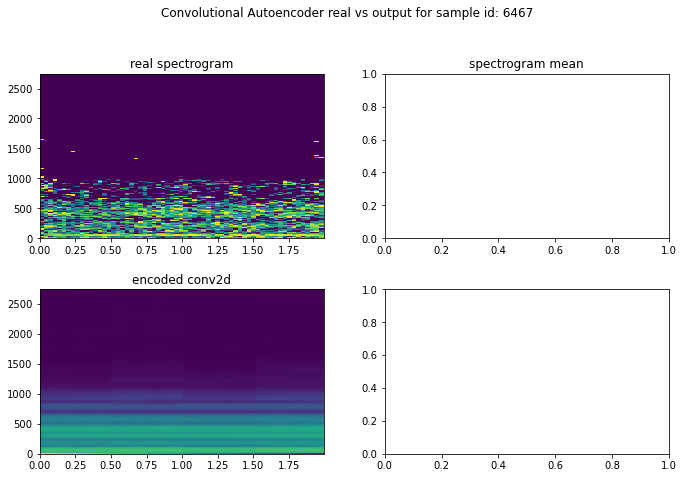

In [60]:
import matplotlib.pyplot as plt
import random
import torch
from scipy.io import wavfile


# read just sample file as probably all has the same sampling rate
sample_rate, samples = wavfile.read('C:\\Users\\tymot\\projects\\001.smartula\\smartula-analysis\\smartula-analysis'
                           '\\measurements\\smartulav2\\smrpiclient6_10082020-15092020\\DEADBEEF94-2020-08-10T03-11-50.wav')
idx = random.randint(0, len(hives_data) - 1)
with torch.no_grad():   
    modelConvAE.eval()
    modelBasicAE.eval()
    
    fig, axs = plt.subplots(2, 2, figsize=(10,7))
    fig.suptitle(f'Convolutional Autoencoder real vs output for sample id: {idx}')
    fig.tight_layout(pad = 3.0)

    frequencies = librosa.fft_frequencies(sr=sample_rate, n_fft=nfft)
    freq_slice = np.where((frequencies < fmax))
    frequencies = frequencies[freq_slice]
    times = (np.arange(0, scaled_spectrogram[idx].shape[1])*hop_len)/sample_rate
    elem = scaled_spectrogram[idx]
    elem = elem[None, None,: ,:]
    elem = torch.Tensor(elem).to(device)
    
    elem_mean = scaled_spectrograms_means[idx]
    elem_mean = elem_mean[None, :]
    elem_mean = torch.Tensor(elem_mean).to(device)
    
    axs[0][0].set_title('real spectrogram')
    axs[0][0].pcolormesh(times, frequencies, scaled_spectrogram[idx])
    axs[1][0].set_title('encoded conv2d')
    axs[1][0].pcolormesh(times, frequencies, modelConvAE(elem.to(device)).cpu().numpy().squeeze())
    
    # Get just one sample for the frequencies
    freqs = hives_data[0]['freq']['spectrogram']['frequencies']
    axs[0][1].set_title('spectrogram mean')
    axs[0][1].plot(freqs, scaled_spectrograms_means[idx], label='real', color='blue')
    axs[0][1].plot(freqs, modelBasicAE(elem_mean).cpu().numpy().squeeze(), label='encoded', color='red')
    axs[0][1].legend()

    plt.show()

# Add temperature/humidity/gas

In [12]:
from utils.data_utils import read_sensor_data

start_time = '2020-08-10 00:00:00'
end_time = '2020-09-16 00:00:00'
print(f"extracting data for hive under analysis: {hive_under_analysis} from {start_time} to {end_time}...")

df_hives_sound = pd.DataFrame(sounds_data)
df_hive_sound_ua = df_hives_sound[(df_hives_sound['name'] == hive_under_analysis)
                                 & (df_hives_sound['datetime'] > start_time)
                                 & (df_hives_sound['datetime'] < end_time)]
df_hive_sound_ua.set_index('datetime', inplace=True)
print(f"-> prepared base of {df_hive_sound_ua.count()['spectrogram']} number of sound spectrums <-")

df_hive_temperature_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-temperature.csv',
                                          hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'temperature')
df_hive_humidity_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-humidity.csv',
                                       hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'humidity')
df_hive_alcohol_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-alcohol.csv',
                                      hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'alcohol')
df_hive_aceton_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-aceton.csv',
                                     hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'aceton')
df_hive_amon_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-jon-amonowy.csv',
                                   hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'jon-amonowy')
df_hive_toluen_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-toluen.csv',
                                     hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'toluen')
df_hive_co2_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-co2.csv',
                                    hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'co2')
df_hive_siarkowodor_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-siarkowodor.csv',
                                          hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'siarkowodor')
df_hive_metanotiol_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-metanotiol.csv',
                                         hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'metanotiol')
df_hive_trimetyloamina_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-trimetyloamina.csv',
                                         hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'trimetyloamina')
df_hive_wodor_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-wodor.csv',
                                    hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'wodor')
df_hive_co_ua = read_sensor_data('..//measurements//smartulav2//sulmin-10082020-15092020-inside-co.csv',
                                 hive_under_analysis, hives_ids, start_time, end_time, timezone_offset_hours, 'co')


extracting data for hive under analysis: smrpiclient7 from 2020-08-10 00:00:00 to 2020-09-16 00:00:00...
-> prepared base of 3367 number of sound spectrums <-
got 3488 of temperature samples
got 3488 of humidity samples
got 5141 of alcohol samples
got 5141 of aceton samples
got 5141 of jon-amonowy samples
got 5141 of toluen samples
got 5141 of co2 samples
got 5129 of siarkowodor samples
got 5129 of metanotiol samples
got 5129 of trimetyloamina samples
got 5129 of wodor samples
got 5112 of co samples


Check autocorrelation for specific features

In [15]:
from utils.data_utils import merge_dataframes_ontimestamp, merge_columns
from utils.autoencoder_utils import conv2d_encode, basic_ae_encode

df_hive_data = merge_dataframes_ontimestamp(df_hive_sound_ua,
                                            df_hive_temperature_ua, df_hive_humidity_ua,
                                            df_hive_alcohol_ua, df_hive_aceton_ua, df_hive_amon_ua, df_hive_toluen_ua, df_hive_co2_ua,
                                            df_hive_siarkowodor_ua, df_hive_metanotiol_ua, df_hive_trimetyloamina_ua, df_hive_wodor_ua,
                                            df_hive_co_ua)

df_hive_data['conv_ae'] = conv2d_encode(modelConvAE, df_hive_data['spectrogram'].to_list())
df_hive_data['basic_ae'] = basic_ae_encode(modelBasicAE, df_hive_data['spectrogram_mean'].to_list())

df_hive_data['bae_feature_vector'] = merge_columns(df_hive_data, ['basic_ae', 'humidity', 'temperature', 
                                                                  'alcohol', 'aceton', 'jon-amonowy', 'toluen', 'co2', 'trimetyloamina', 'co'])
df_hive_data['conv_feature_vector'] = merge_columns(df_hive_data, ['conv_ae', 'humidity', 'temperature', 
                                                                  'alcohol', 'aceton', 'jon-amonowy', 'toluen', 'co2', 'trimetyloamina', 'co'])
df_hive_data['mfcc_feature_vector'] = merge_columns(df_hive_data, ['mfccs', 'humidity', 'temperature', 
                                                                  'alcohol', 'aceton', 'jon-amonowy', 'toluen', 'co2', 'trimetyloamina', 'co'])

# SVM classification 

In [16]:
from sklearn.preprocessing import StandardScaler
from utils.data_utils import search_best_night_day

start_hours = [20, 21, 22, 23, 0, 1, 2, 3, 4]

# data for convolutional autoencoder
pd_convae_data = pd.DataFrame(df_hive_data)
pd_convae_data['conv_feature_vector'] = StandardScaler().fit_transform(df_hive_data['conv_feature_vector'].values.tolist()).tolist()

# data for basic autoencoder
pd_convae_data = pd.DataFrame(df_hive_data)
pd_convae_data['bae_feature_vector'] = StandardScaler().fit_transform(df_hive_data['bae_feature_vector'].values.tolist()).tolist()

# data for mfcc features
pd_convae_data = pd.DataFrame(df_hive_data)
pd_convae_data['mfcc_feature_vector'] = StandardScaler().fit_transform(df_hive_data['mfcc_feature_vector'].values.tolist()).tolist()

# data for plain mfcc 
mfccs = [hive_data['features']['mfcc_avg'] for hive_data in hives_data if hive_data['id'] == hive_under_analysis]
mfccs = StandardScaler().fit_transform(mfccs)
datetimes = [hive_data['datetime'] for hive_data in hives_data if hive_data['id'] == hive_under_analysis]
mfccs_data = list(zip(datetimes, mfccs))
pd_mfcc_data = pd.DataFrame(mfccs_data, columns=['datetime', 'mfcc'])
pd_mfcc_data.set_index('datetime', inplace=True)

# calculate one class SVM match
print('calculating mfccs match...', end=' ', flush=True)
mfcc_accs = search_best_night_day(pd_mfcc_data, 'mfcc', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(mfcc_accs)}/{len(mfcc_accs[0])}')
print('calculating conv ae feature vector match...', end=' ', flush=True)
conv_ae_accs = search_best_night_day(pd_convae_data, 'conv_feature_vector', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(conv_ae_accs)}/{len(conv_ae_accs[0])}')
print('calculating basic ae feature vector match...', end=' ', flush=True)
bae_accs = search_best_night_day(pd_convae_data, 'bae_feature_vector', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(bae_accs)}/{len(bae_accs[0])}')
print('calculating mfccs extended feature vector match...', end=' ', flush=True)
mffce_accs = search_best_night_day(pd_convae_data, 'mfcc_feature_vector', days_as_test=10, start_hours=start_hours, max_shift=6, verbose=0)
print(f'done. {len(mffce_accs)}/{len(mffce_accs[0])}')

calculating mfccs match... done. 6/9
calculating conv ae feature vector match... done. 6/9
calculating basic ae feature vector match... done. 6/9
calculating mfccs extended feature vector match... done. 6/9


C:\Users\tymot\projects\001.smartula\smartula-analysis\smartula-analysis\notebooks\utils\data_utils.py:144: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


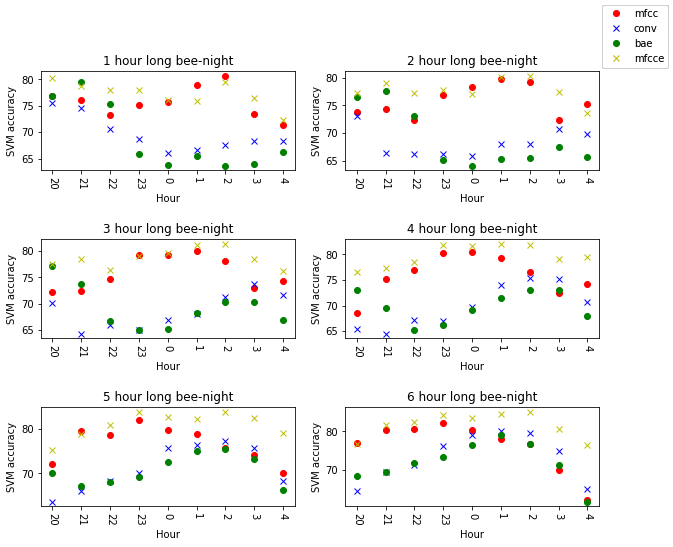

In [17]:
from utils.data_utils import plot_hour_shift

plot_hour_shift(mfcc_accs, conv_ae_accs, bae_accs, mffce_accs,
                labels_list=['mfcc', 'conv', 'bae', 'mfcce'], xticklabels=[str(start_hour) for start_hour in start_hours])

Visualize on 2D map, we basically perform TSNE and PCA dimension reduction in order to visualize night and day. Probably this will be not efficent but it is worth to give a shot.

C:\Users\tymot\programs\anaconda\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
C:\Users\tymot\programs\anaconda\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


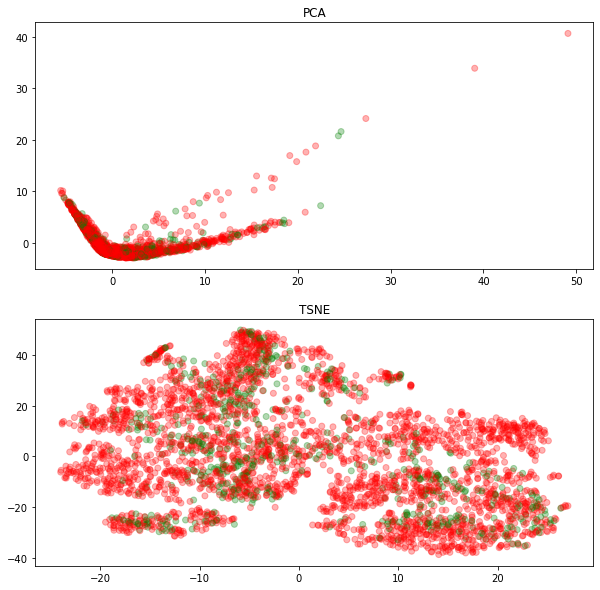

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

start_hour = 23
end_hour = 2

reduce_df = pd.DataFrame(df_hive_data)
reduce_df['feature_vector'] = StandardScaler().fit_transform(df_hive_data['bae_feature_vector'].values.tolist()).tolist()

reduced_ae_pca = PCA(n_components=2).fit_transform(reduce_df['feature_vector'].values.tolist())
reduced_ae_tsne =  TSNE(n_components=2, perplexity=100, learning_rate=500).fit_transform(reduce_df['feature_vector'].values.tolist())
is_night_list = (reduce_df.index.hour >= start_hour) | (reduce_df.index.hour <= end_hour)
                
colors = ['red', 'green', 'blue', 'yellow']
labels = ['day', 'night']

fig, axs = plt.subplots(2, figsize=(10,10))

axs[0].scatter(x=[data[0] for data in reduced_ae_pca],
               y=[data[1] for data in reduced_ae_pca],
               c=[colors[night] for night in is_night_list],
              alpha=0.3)
axs[0].set_title('PCA')

axs[1].scatter(x=[data[0] for data in reduced_ae_tsne],
               y=[data[1] for data in reduced_ae_tsne],
               c=[colors[night] for night in is_night_list],
              alpha=0.3)
axs[1].set_title('TSNE')

plt.show()

In [ ]:
pca = PCA().fit(reduce_df['feature_vector'].values.tolist())

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');




In [ ]:
import matplotlib

def plot_distribution(distribution_dict, bin_size):
    """ Plotting distribiution for dictionary elements"""
    colors = ['blue', 'green', 'red', 'yellow', 'black', 'pink', 'purple']
    rms_max = 0
    rms_min = 65535
    for k, v in rmses.items():
        if np.max(v) > rms_max:
            rms_max = np.max(v)
        if np.min(v) < rms_min:
            rms_min = np.min(v)
        
    plt.figure()
    for idx, (k, v) in enumerate(distribution_dict.items()):
        plt.hist(v, color=colors[idx%len(colors)], bins=int(np.abs(rms_max-rms_min)/bin_size))
    plt.show()

Part of code for calculating autocorrelaction for specific feature

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

%matplotlib widget

features = ['conv_ae', 'humidity', 'temperature',
            'alcohol', 'aceton', 'jon-amonowy',
            'toluen', 'co2', 'siarkowodor',
            'metanotiol', 'trimetyloamina', 'wodor', 'co']

feature = features[12]
data_to_autocorr = df_hive_co_ua

roll_len = 3
interval = (data_to_autocorr.index[2] - data_to_autocorr.index[1]).seconds//60%60

y2 = data_to_autocorr[feature].rolling(window=roll_len).mean().values
y_corr = y2[roll_len:]
x_corelation = np.arange(start=0, step=2, stop=150)

fig, axes = plt.subplots(1, figsize=(8,5))
x = plot_acf(y_corr, lags=x_corelation, zero=False, ax=axes)
x_raw = acf(y_corr, nlags=150)
axes.set_title(f'{feature} autocorrelaction')
axes.set_xlabel(f'Lag (1 lag = {interval} minutes)') 
axes.set_ylabel('Correlation')
axes.set_xticks(np.arange(0, 151, step=10))

print(f'{feature} with max {max(x_raw[60:]):.2f} at {60 + np.argmax(x_raw[60:])}')

# temperature with max 0.74 at 93 (15 mint)
# humidity with max 0.58 at 92 (15 min)
# alcohol with max 0.53 at 134 (10 min)
# aceton with max 0.52 at 133 (10 min)
# jon-amonowy with max 0.57 at 133 (10 min)
# toluen with max 0.52 at 134 (10 min)
# co2 with max 0.54 at 133 (10 min)
# siarkowodor with max 0.16 at 142 (10 min)
# metanotiol with max 0.34 at 140 (10 min)
# trimetyloamina with max 0.56 at 138 (10 min)
# wodor with max 0.14 at 142 (10 min)
# co with max 0.62 at 134 (10 min)

In [ ]:
import importlib
import utils.autoencoder_utils as ae
import utils.data_utils as du

importlib.reload(ae)
